# VAEについて調査&実装してみる

- 目的
    - VAEを生成モデルの代表的なものとみなして事後確率分布のモデル化が可能かを検証する
- 目標
    - 識別タスクをお題として、入力空間における分布$p(x|C_k)$をモデル化したのちにベイズの公式を用いて事後確率$p(C_k|x)$を実際に計算してみる
- 手段
    - mnist手書き数字にて、数字の0とそれ以外の2クラス識別タスクを学習。例えば6のように見える0は事後確率分布がばらつくかどうかを確かめてみる

## VAEによる確率分布$p(x|C_k)$のモデル化

VAEは生成モデルであるから$p(x|C_k)$をガウス分布として表現することができるはず。まずはこれを実装してみる。

適切に訓練できれば、数字の0をエンコーダに入力したときの出力がガウス分布に従っているはず。これを確かめてみよう。

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2023-10-29 15:19:25.818704: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-29 15:19:25.818807: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-29 15:19:25.818842: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-29 15:19:25.827378: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


2023-10-29 15:19:27.375985: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-29 15:19:27.379807: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-29 15:19:27.379843: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt


In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [9]:
latent_dim = 2
batch_size = 128
epochs = 10

In [10]:
# エンコーダーの定義
inputs = Input(shape=(original_dim,), name='encoder_input')
x = Dense(512, activation='relu')(inputs)
x = Dense(256, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# 潜在変数のサンプリング関数の定義
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + tf.keras.backend.exp(z_log_var) * epsilon

# 潜在変数のサンプリング関数を使用して、潜在変数zを生成します。
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# デコーダーの定義
decoder_input = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(256, activation='relu')(decoder_input)
x = Dense(512, activation='relu')(x)
outputs = Dense(original_dim, activation='sigmoid')(x)

# エンコーダーとデコーダーを結合してVAEモデルを作成します。
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_input, outputs, name='decoder')
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

In [11]:
reconstruction_loss = mse(inputs, outputs) * original_dim
kl_loss = 1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var)
kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Epoch 1/10
469/469 [==============================] - 7s 12ms/step - loss: 49.4544 - val_loss: 42.0882
Epoch 2/10
469/469 [==============================] - 6s 13ms/step - loss: 40.5236 - val_loss: 39.1792
Epoch 3/10
469/469 [==============================] - 6s 12ms/step - loss: 38.4423 - val_loss: 37.6253
Epoch 4/10
469/469 [==============================] - 6s 12ms/step - loss: 37.1109 - val_loss: 36.5844
Epoch 5/10
469/469 [==============================] - 6s 13ms/step - loss: 36.2876 - val_loss: 36.0654
Epoch 6/10
469/469 [==============================] - 6s 13ms/step - loss: 35.6409 - val_loss: 35.4964
Epoch 7/10
469/469 [==============================] - 6s 13ms/step - loss: 35.1424 - val_loss: 35.0118
Epoch 8/10
469/469 [==============================] - 6s 12ms/step - loss: 34.6909 - val_loss: 34.8111
Epoch 9/10
469/469 [==============================] - 6s 12ms/step - loss: 34.3555 - val_loss: 34.5652
Epoch 10/10
469/469 [==============================] - 6s 13ms/step - los

1/1 [==============================] - 0s 74ms/step


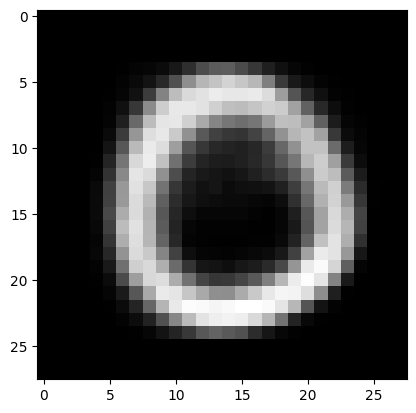

In [12]:
# 数字6の潜在表現を生成します。
latent_representation = np.array([[0.1,-0.1]])

# デコーダーを使用して、数字6の画像を生成します。
generated_image = decoder.predict(latent_representation)

# 生成された画像を表示します。
plt.imshow(generated_image.reshape(28,28), cmap="gray")
plt.show()

In [29]:
x = np.arange(-1, 1.1, 0.5)
y = np.arange(-1, 1.1, 0.5)

xx, yy = np.meshgrid(x, y)
data = np.array([xx.ravel(), yy.ravel()]).T

data.shape

(25, 2)

In [30]:
latent_representation.shape

(1, 2)

In [31]:
list_generated_image = []
for i in data:
    # print(i.reshape(1,2).shape)
    list_generated_image.append(decoder.predict(i.reshape(1,2)))

1/1 [==============================] - 0s 16ms/step


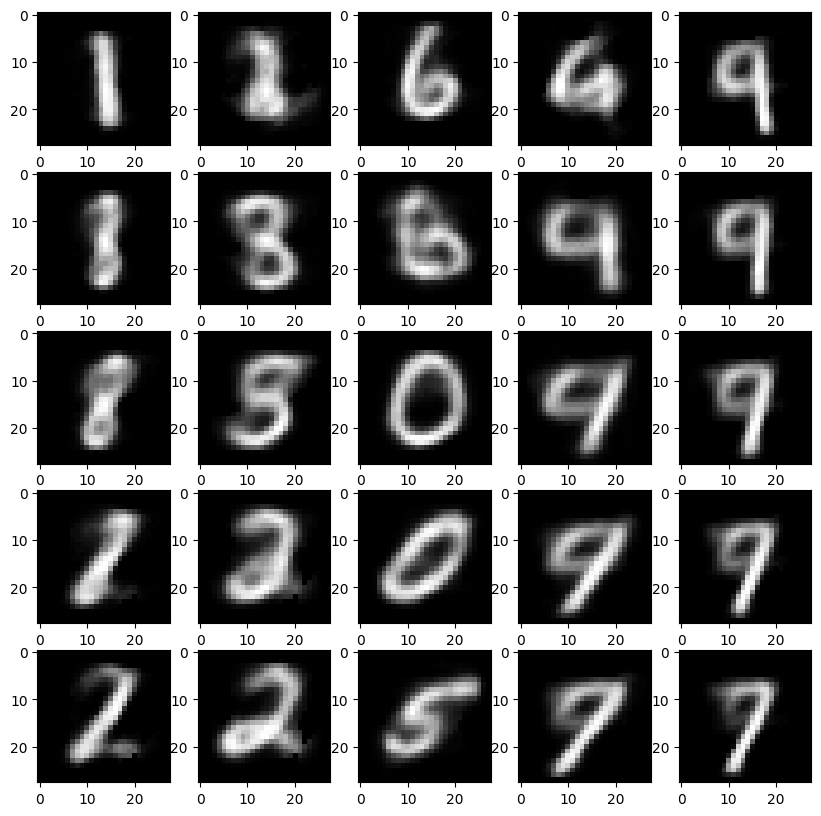

In [32]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 5, figsize=(10, 10))
cnt=0
for i in range(5):
    for j in range(5):
        axs[i, j].imshow(list_generated_image[cnt].reshape(28,28), cmap="gray")
        cnt+=1
plt.show()